# Приоритизация гипотез и А/В тестирование для интернет-магазина

##  Введение

### Описание данных

Мы получили для анализа три таблицы. 

1) Файл с гипотезами по увеличению выручки интернет-магазина.
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

2) Файл с данными о заказах.
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

3) Файл с данными о посещениях сайта в конкретную дату.
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

### Задача исследования

Приоритизировать гипотезы по увеличению выручки интернет-магазина, запустить A/B-тест и проанализировать его результаты. По итогам анализа принять решение: 
1. Остановить тест, зафиксировать победу одной из групп. 
2. Остановить тест, зафиксировать отсутствие различий между группами. 
3. Продолжить тест.

###  Шаги исследования

1. Применить фреймворки ICE и RICE для приоритизации гипотез, отсортировать их по убыванию приоритета. Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE и объяснить, почему так произошло.

2. Проанализировать результаты А/В теста.
    1) Построить графики:
        - кумулятивной выручки по группам
        - кумулятивного среднего чека по группам
        - относительного изменения кумулятивного среднего чека группы B к группе A
        - кумулятивного среднего количества заказов по группам
        - относительного изменения кумулятивного среднего количества заказов группы B к группе A
        - точечный график количества заказов по пользователям
        - точечный график стоимостей заказов
       Сделать выводы и предположения по каждому из них
       
    2) Посчитать 95-й и 99-й перцентили количества заказов на пользователя и стоимости заказов. Выбрать границу для определения аномальных пользователей и заказов.

    3) Посчитать статистическую значимость различий:
        - в среднем количестве заказов между группами по «сырым» данным
        - в среднем чеке заказа между группами по «сырым» данным
        - в среднем количестве заказов между группами по «очищенным» данным
        - в среднем чеке заказа между группами по «очищенным» данным
       Сделать выводы и предположения по каждому пункту

    3) Принять решение по результатам теста и объяснить его.

## Подготовка данных

In [1]:
# импортируем нужные библиотеки

import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# загрузим данные

hypos = pd.read_csv(r"C:\Users\bonny\Desktop\мои_проекты_практикум\проект_7_а_в_тесты\hypothesis.csv")
orders = pd.read_csv(r"C:\Users\bonny\Desktop\мои_проекты_практикум\проект_7_а_в_тесты\orders.csv") 
visitors = pd.read_csv(r"C:\Users\bonny\Desktop\мои_проекты_практикум\проект_7_а_в_тесты\visitors.csv")

In [3]:
hypos.head(10) # изучим таблицу с гипотезами

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
hypos.columns = hypos.columns.str.lower() # приведем названия столбцов к нижнему регистру

In [5]:
orders.info() # изучим инфо о таблице с заказами и посмотрим на первые 5 ее строк
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [6]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group'] 
# переименуем столбцы в соответствии с принятым стилем

In [7]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) 
# приведем дату в нужный формат

In [8]:
orders.duplicated().sum() # проверим, нет ли в таблице дубликатов

0

In [9]:
visitors.info() #изучим инфо о таблице с клиентами и посмотрим на первые 5 ее строк
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) 
# приведем дату в нужный формат

In [11]:
visitors.duplicated().sum() # проверим, нет ли в таблице дубликатов

0

В таблицах нет пропусков и дубликатов, данные в нужном формате, а названия столбцов соответствуют принятому стилю. Данные готовы к анализу.

## Приоритизация гипотез

### Фреймворк ICE

In [12]:
hypos['ICE'] = (hypos['impact']*hypos['confidence'])/hypos['efforts']

pd.options.display.max_colwidth = 400
display(hypos.iloc[:,[0, -1]].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


### Фреймворк RICE

In [13]:
hypos['RICE'] = (hypos['reach']*hypos['impact']*hypos['confidence'])/hypos['efforts']

display(hypos.iloc[:,[0, -1]].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Вывод

При применении фреймворка ICE лидируют гипотезы 8, 0 и 7 (по убыванию приоритета), а при фреймворке RICE - 7, 2 и 0. Как мы видим, две гипотезы из тройки лидеров в обоих случаях одинаковы, но меняется их порядок. 

Отличие фреймворков ICE и RICE в том, что последний учитывает не только Impact (насколько сильно изменение повлияет на пользователей), Confidence (насколько вы уверены, что это изменение повлияет на
пользователей именно так) и Efforts (сколько стоит протестировать эту гипотезу), но и Reach (скольких пользователей затронет изменение, которое вы хотите внести). Если для нашего интернет-магазина Reach - важный параметр, то следует приоритизировать гипотезу 7 - «Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок», а если нет, то гипотезу 8 - «Запустить акцию, дающую скидку на товар в день рождения».

## Анализ A/B-теста

In [14]:
# проверим, нет ли у нас пользователей, попавших в обе группы

group_a = orders[orders['group']=='A']['visitor_id']
group_b = orders[orders['group']=='B']['visitor_id']

doubles = []

for i in group_a:
    if i in doubles:
        continue
    for j in group_b:
        if i == j:
            doubles.append(i)
            break
 
print(len(doubles))

58


In [15]:
# 58 человек попали в обе группы. посчитаем, какая это доля пользователей

print(len(doubles)/orders['visitor_id'].nunique()*100)

5.625606207565471


In [16]:
# это меньше 6%. удалим эти id из таблицы orders, чтобы они не искажали нам выводы

orders = orders.query('visitor_id not in @doubles')

Прежде чем приступать к построению графиков, расчетам и выводам, создадим таблицу с кумулятивными данными о заказах, которой будем пользоваться в дальнейшем.

In [17]:
# создадим массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получим агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединим кумулятивные данные в одной таблице и присвоим ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


### Кумулятивная выручка по группам

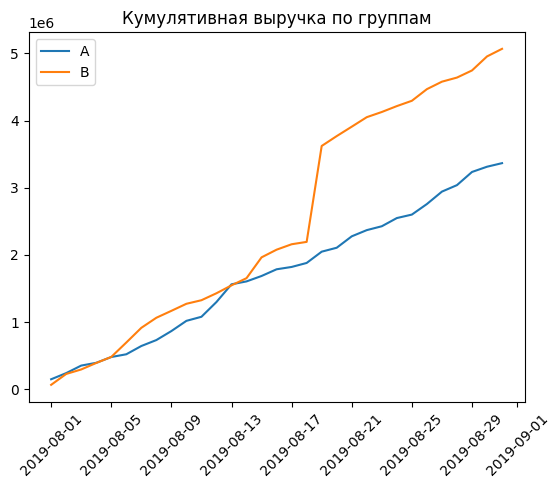

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.legend()
plt.title("Кумулятивная выручка по группам")
plt.xticks(rotation=45)
plt.show()

Выручка увеличивается в течение всего теста в обеих группах. При этом мы видим небольшие скачки на обоих графиках и один очень резкий скачок в группе В. Возможная причина этого - появление очень дорогого заказа в выборке, но чтобы ответить точно, нам нужно больше данных. Мы рассмотрим это ниже.

### Кумулятивный средний чек по группам

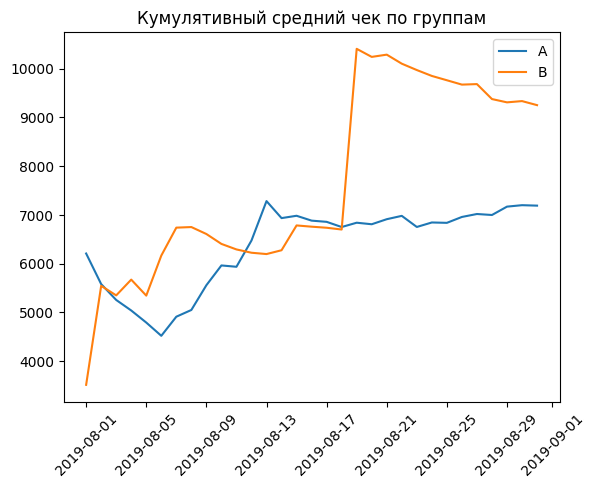

In [19]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.legend()
plt.title("Кумулятивный средний чек по группам")
plt.xticks(rotation=45)
plt.show()

Мы видим большие колебания в размере среднего чека в обеих группах. Резкий скачок на графике группы В, который мы наблюдали на предыдущем графике, есть и здесь. Значит, наше предположение было верным, в этот день был аномально крупный заказ. 

Примерно в последней трети теста колебания становятся значительно меньше, и мы видим, что средний чек группы А выровнялся, а группы В постепенно уменьшался.

### Относительное изменение кумулятивного среднего чека группы B к группе A

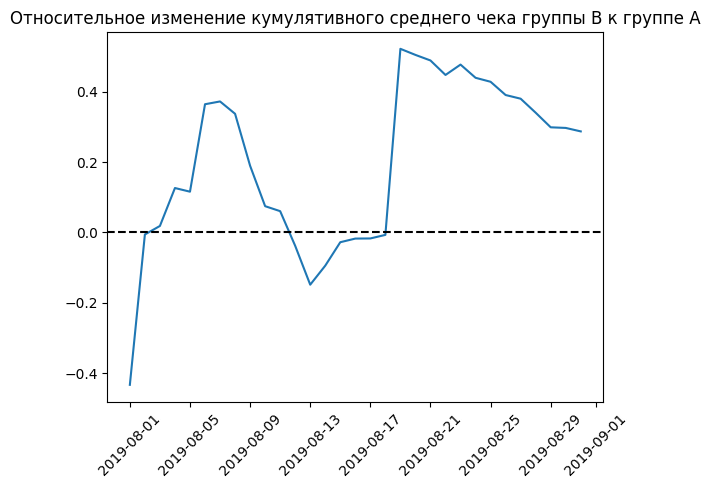

In [20]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])/(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title("Относительное изменение кумулятивного среднего чека группы B к группе A")
plt.xticks(rotation=45)
plt.show()

Как мы видим, средний чек в группе В почти всегда выше, чем в группе А. На графике также есть несколько резких скачков - в выборке наверняка есть аномально дорогие заказы. 

### Кумулятивное среднее количество заказов по группам

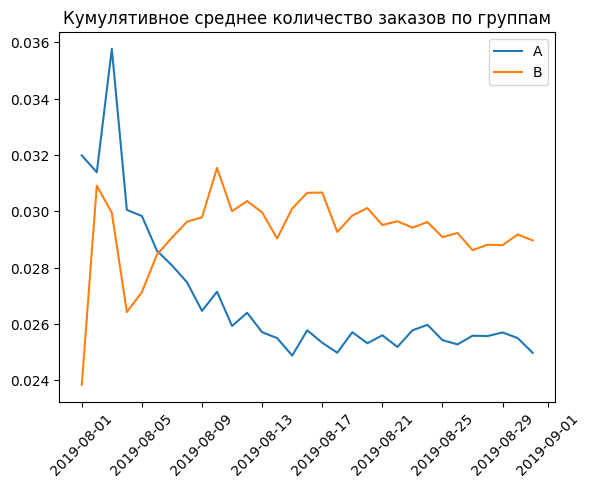

In [21]:
# считаем кумулятивное среднее к-во заказов
cumulative_data['cum_avg_orders'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_avg_orders_a = cumulative_data[cumulative_data['group']=='A'][['date', 'cum_avg_orders']]

# отделяем данные по группе B
cumulative_avg_orders_b = cumulative_data[cumulative_data['group']=='B'][['date', 'cum_avg_orders']]

# строим графики
plt.plot(cumulative_avg_orders_a['date'], cumulative_avg_orders_a['cum_avg_orders'], label='A')
plt.plot(cumulative_avg_orders_b['date'], cumulative_avg_orders_b['cum_avg_orders'], label='B')
plt.legend()
plt.title("Кумулятивное среднее количество заказов по группам")
plt.xticks(rotation=45)
plt.show()

Как мы видим, графики обеих групп нестабильны на протяжении всего теста, скачки есть в обеих группах. Но в любом случае, примерно с 07.08. количество заказов в группе В значительно больше, чем в группе А.

### Относительное изменение кумулятивного среднего количества заказов группы B к группе A

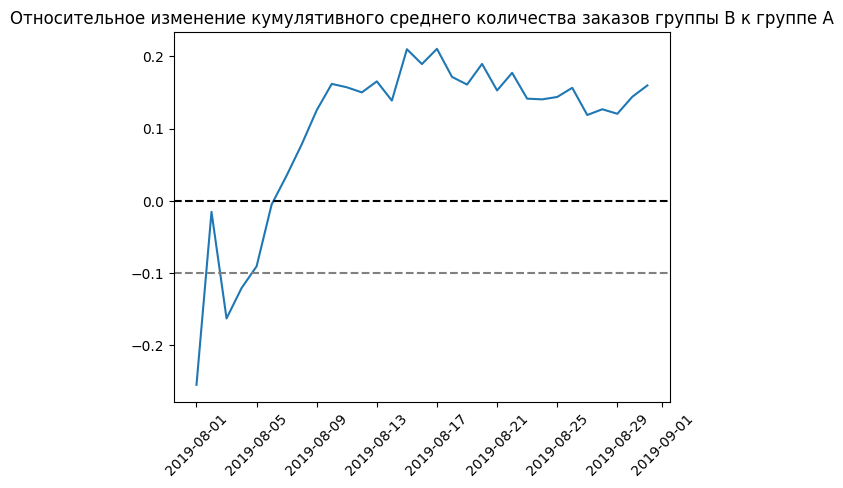

In [22]:
merged_cum_avg_orders = cumulative_avg_orders_a[['date','cum_avg_orders']].merge(cumulative_avg_orders_b[['date','cum_avg_orders']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.plot(merged_cum_avg_orders['date'], merged_cum_avg_orders['cum_avg_orders_b']/merged_cum_avg_orders['cum_avg_orders_a']-1)


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.title("Относительное изменение кумулятивного среднего количества заказов группы B к группе A")
plt.xticks(rotation=45)
plt.show()

Мы видим, что кумулятивное среднее количество заказов в группе В стабильно превышает этот показатель в группе А.

### Количество заказов по пользователям

In [23]:
# создадим таблицу с к-вом заказов по пользователям

orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

orders_by_users.columns = ['visitor_id', 'orders']

display(orders_by_users.sort_values(by='orders', ascending=False).head(10))

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


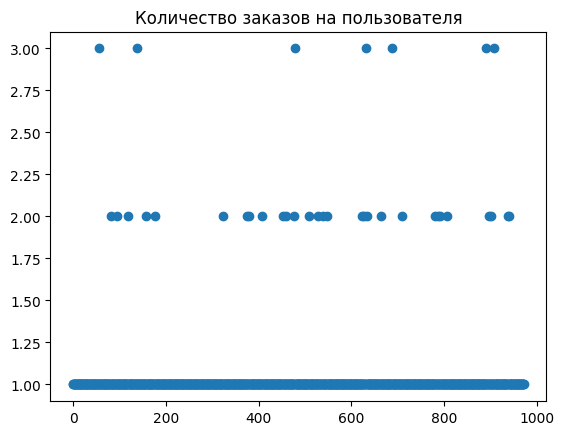

In [24]:
# построим точечный график количества заказов по пользователям

x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders'])
plt.title("Количество заказов на пользователя")
plt.show()

In [25]:
# посчитаем 95-й и 99-й перцентили количества заказов на одного пользователя:

print(np.percentile(orders_by_users['orders'], [95, 99])) 

[1. 2.]


Менее 1% пользователей сделали больше 2х заказов. Раз абсолютное большинство делали один заказ, считаем оправданным задать 1 заказ как верхнюю границу и отсеять аномальных пользователей по ней, чтобы выбросы не искажали результаты эксперимента.

### Стоимость заказов

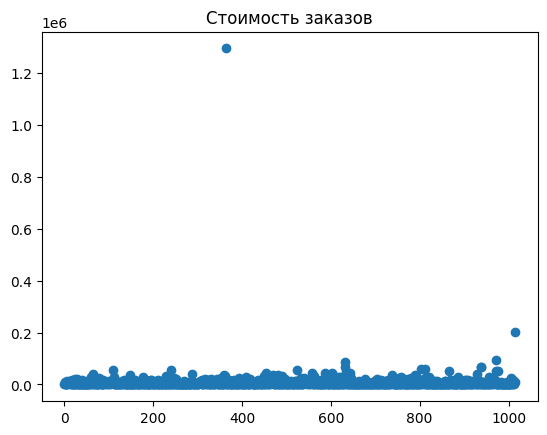

In [26]:
# построим точечный график стоимости заказов

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title("Стоимость заказов")
plt.show()

In [27]:
# посчитаем 95-й и 99-й перцентили стоимости заказов

print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Только 5% покупателей оформили заказ дороже 26785 рублей, и только 1% - дороже 53904. Отсеем покупки дороже 27000, чтобы не искажать результаты аномалиями.

### Статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным

Сформулируем гипотезы. 

Н0: различий в среднем количестве заказов между группами нет. 

Н1: различия в среднем между группами есть.

In [28]:
# создадим таблицу с посетителями сайта в каждый день из группы А
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

# создадим таблицу с кумулятивным к-вом посетителей сайта для группы А
visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

# создадим таблицу с посетителями сайта в каждый день из группы В
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

# создадим таблицу с кумулятивным к-вом посетителей сайта для группы В
visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

# создадим таблицу с заказами по дням для группы А
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

# создадим таблицу с кумулятивными заказами по дням для группы А
orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

# создадим таблицу с заказами по дням для группы В
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

# создадим таблицу с кумулятивными заказами по дням для группы В
orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

# объединим созданные таблицы в один датафрейм
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

# создадим таблицу с заказами группы А
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

# создадим таблицу с заказами группы В
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']


# создадим выборки 
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)


In [29]:
print('p-value:',"{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print('Относительный прирост среднего числа заказов группы B:', "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

p-value: 0.011
Относительный прирост среднего числа заказов группы B: 0.160


По «сырым» данным различия в среднем числе заказов групп A и B есть. Значение p-value меньше 0,05. Значит, мы отвергаем нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет. Прирост среднего числа заказов группы B относительно группы А составил 16%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Н0: различий в среднем чеке между группами нет. 

Н1: различия в среднем чеке между группами есть.

In [30]:
print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный рост среднего чека группы B:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
Относительный рост среднего чека группы B: 0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Наблюдаемое различие в почти 29% в относительном росте среднего чека группы В по отношению  к группе А не является статистически значимым и, вероятно, скорректируется на очищенных данных.

###  Статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным

Выше мы посчитали, что 95-й и 99-й перцентили средних чеков равны 26785 и 53904 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказа.

Примем за аномальных пользователей тех, кто совершил больше 1 заказа или совершил заказ дороже 27 000 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.

In [31]:
# сделаем срезы пользователей с числом заказов больше 1
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 1]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 1]['visitor_id'],
    ],
    axis=0,
)

# сделаем срезы пользователей, совершивших заказы дороже 27 000 рублей
users_with_expensive_orders = orders[orders['revenue'] > 27000]['visitor_id']


# объединим всех аномальных пользователей
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [32]:
# выборка А без аномальных пользователей
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# выборка В без аномальных пользователей
sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [33]:
# применим статистический критерий Манна-Уитни к полученным выборкам

print('p-value:',"{0:.3f}".format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))

print('Относительный прирост среднего числа заказов группы B:', "{0:.3f}".format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

p-value: 0.016
Относительный прирост среднего числа заказов группы B: 0.174


Результаты почти не изменились: по-прежнему есть основания отвергнуть нулевую гипотезу, различия между группами есть. На «очищенных» данных количество заказов в группе В по сравнению с группой А еще увеличилось, до 17%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [34]:
print(
    'p-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительный рост среднего чека группы B:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.727
Относительный рост среднего чека группы B: -0.034


Р-value практически не изменился, мы по-прежнему не имеем оснований отвергнуть нулевую гипотезу. Разница между размерами средних чеков групп А и В на очищенных данных практически нивелировалась и не является статистически значимой.

### Заключение

Результаты А/В теста показали, что между группами нет значимой разницы в размере стреднего чека, но есть разница в количестве заказов.

Количество заказов в группе В по сравнению с группой А увеличилось на 17%.

При выросшей конверсии с сохранившимся средним чеком выручка будет расти. Следовательно, группа В показала себя лучше группы А.

Проанализировав данные, считаем, что тест нужно остановить. Победила группа В.